In [2]:
# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization, GaussianNoise
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.regularizers import l1
from keras import initializers
# Random weights kernel_initializer=initializers.RandomNormal(stddev=0.01), 

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer
from sklearn.impute import SimpleImputer

# Evaluating
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt

# Saving model
from keras.models import load_model

imputer = SimpleImputer()
MMS = MinMaxScaler()
RS = RobustScaler()
SS = StandardScaler()
Norm = Normalizer()

%matplotlib inline

In [3]:
# Load in games
data = pd.read_csv('./NBA_SB/Scraping/Games and Stats.csv', parse_dates=['Date'])

data['Home Odds'] = data['Home Odds'].replace(0.00, 1.00)
data['Vis Odds'] = data['Vis Odds'].replace(0.00, 1.00)

# Check for NaNs
print('NA: ',data.isna().sum().sum())
data

NA:  0


,Date,Home Odds,Vis Odds,Home,Visitor,Home PTS,Vis PTS,Home Points Dif,Home Win,H W,...,V Apr1,V Apr2,V MOV,V ORtg,V DRtg,V NRtg,V MOV/A,V ORtg/A,V DRtg/A,V NRtg/A
0,2008-10-05,1.00,1.00,New Orleans Pelicans,Golden State Warriors,106.0,103.0,3.0,True,56,...,3.0,6.0,2.21,112.46,110.24,2.22,2.38,112.59,110.19,2.39
1,2008-10-07,1.42,2.88,Dallas Mavericks,Washington Wizards,108.0,82.0,26.0,True,51,...,5.0,3.0,-0.33,110.03,110.39,-0.36,-0.60,110.06,110.71,-0.65
2,2008-10-07,1.55,2.45,Cleveland Cavaliers,Toronto Raptors,84.0,104.0,-20.0,False,50,...,7.0,3.0,0.99,107.92,106.56,1.36,0.61,107.84,106.91,0.93
3,2008-10-07,1.42,2.88,Dallas Mavericks,Washington Wizards,108.0,82.0,26.0,True,67,...,3.0,8.0,-0.51,110.57,111.28,-0.71,-0.80,110.70,111.71,-1.01
4,2008-10-07,1.37,3.10,Portland Trail Blazers,Sacramento Kings,110.0,81.0,29.0,True,41,...,5.0,4.0,-2.26,108.25,110.71,-2.45,-1.85,108.48,110.51,-2.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18644,2020-10-02,1.17,5.43,Los Angeles Lakers,Miami Heat,124.0,114.0,10.0,True,35,...,3.0,2.0,0.48,107.63,107.12,0.51,0.15,107.47,107.28,0.18
18645,2020-10-04,4.40,1.23,Miami Heat,Los Angeles Lakers,115.0,104.0,11.0,True,44,...,2.0,5.0,-1.55,107.10,108.64,-1.54,-1.43,106.96,108.39,-1.43
18646,2020-10-06,3.76,1.30,Miami Heat,Los Angeles Lakers,96.0,102.0,-6.0,False,44,...,2.0,5.0,-1.55,107.10,108.64,-1.54,-1.43,106.96,108.39,-1.43
18647,2020-10-09,1.31,3.61,Los Angeles Lakers,Miami Heat,108.0,111.0,-3.0,False,35,...,3.0,2.0,0.48,107.63,107.12,0.51,0.15,107.47,107.28,0.18


In [4]:
# Check baseline percentage wins

home_fav = data[data['Home Odds'] < data['Vis Odds']]
vis_fav = data[data['Home Odds'] > data['Vis Odds']]
home_fav_win = home_fav[home_fav['Home Win'] == True]
vis_fav_win = vis_fav[vis_fav['Home Win'] == False]

print('Home Favourite Wins: ',len(home_fav_win) / len(home_fav))
print('Visitor Favourite Wins: ',len(vis_fav_win) / len(vis_fav))
print('Favourite Wins: ',(len(home_fav_win) + len(vis_fav_win)) / (len(home_fav) + len(vis_fav)))

print('Home Wins: ',len(data[data['Home Win'] == True]) / len(data))

Home Favourite Wins:  0.702825308396339
Visitor Favourite Wins:  0.6483196159122085
Favourite Wins:  0.6855465565037778
Home Wins:  0.5908091586680251


In [5]:
# Select the data
x = data.loc[:,'H W':]
x['Home Odds'], x['Vis Odds'] = [data['Home Odds'], data['Vis Odds']]
y = data['Home Win']

# Scale data
x = x.astype(float)
for col in x.columns:
    x[col] = (x[col]-x[col].min()) / (x[col].max() - x[col].min())

# Split the data into train, test and valid
def split_data(x, y, split):
    
    # split train and test
    n_train = int(split * float(x.shape[0]))
    trainX, testX = x.iloc[:n_train, :], x.iloc[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    return trainX, testX, trainy, testy

trainX, testX, trainy, testy = split_data(x, y, 0.8)
testX, validX, testy, validy = split_data(testX, testy, 0.5)

In [12]:
# Create the model
model = Sequential()
model.add(Dense(x.shape[1], input_dim=x.shape[1], activation='relu'))
model.add(Dense(236, activation='relu'))
model.add(Dense(118, activation='relu'))
model.add(Dense(59, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# sgd = SGD(lr=0.0001, momentum=0)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# LEARNING RATE SCHEDULE
rlrp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_delta=1E-7, verbose=1)
# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.fit(x, y, epochs=20, batch_size=10, validation_split=0.2, verbose=1, callbacks=[rlrp, es])

# model.fit(x_scale, y, epochs=10, batch_size=1, validation_split=0.2, verbose=1)

Epoch 1/20
1492/1492 [==============================] - 3s 2ms/step - loss: 0.6504 - accuracy: 0.6191 - val_loss: 0.6374 - val_accuracy: 0.6338
Epoch 2/20
1492/1492 [==============================] - 3s 2ms/step - loss: 0.6133 - accuracy: 0.6543 - val_loss: 0.6193 - val_accuracy: 0.6625
Epoch 3/20
1492/1492 [==============================] - 3s 2ms/step - loss: 0.6013 - accuracy: 0.6724 - val_loss: 0.6179 - val_accuracy: 0.6601
Epoch 4/20
1492/1492 [==============================] - 3s 2ms/step - loss: 0.5997 - accuracy: 0.6711 - val_loss: 0.6180 - val_accuracy: 0.6622
Epoch 5/20
1492/1492 [==============================] - 3s 2ms/step - loss: 0.5979 - accuracy: 0.6733 - val_loss: 0.6347 - val_accuracy: 0.6324
Epoch 6/20
1492/1492 [==============================] - 3s 2ms/step - loss: 0.5962 - accuracy: 0.6772 - val_loss: 0.6230 - val_accuracy: 0.6584
Epoch 7/20
1492/1492 [==============================] - 3s 2ms/step - loss: 0.5952 - accuracy: 0.6742 - val_loss: 0.6154 - val_accuracy:

In [13]:
model.save('Odds_Model.h5')

In [6]:
model = load_model('Odds_Model.h5')

In [12]:
def make_preds(model, df):
    # Check predictions
    preds = model.predict(df)

    # Create results df
    results = data[['Date', 'Home Odds', 'Vis Odds', 'Home Win']]
#     results = results.iloc[14919:16784,:]

    results['Preds'] = preds
    print(results.head())
    return results

In [8]:
# Functions to test thresholds
def create_threshold_df(df, col):
    # Create dictionary of accuracy of predictions for each prediction threshold

    accuracy_dict = {'Threshold': [],'Bet on Win':[], 'Accurate Wins': [], 'Bet on Loss':[], 'Accurate Losses': []}

    for x in range(30, 90):
        threshold = x / 100
        # Count how many times Ensemble > 1.06 (Predicted Win) and Home win == True (Actual Win)

        bet_wins = len(df[df[col] > threshold])
        bet_losses = len(df[df[col] < threshold])

        wins = df.apply(lambda x: True if x[col] > threshold and x['Home Win'] == True else False, axis=1)
        losses = df.apply(lambda x: True if x[col] < threshold and x['Home Win'] == False else False, axis=1)
        win_perc = (len(wins[wins == True]) / len(df[df[col] > threshold]) * 100)
        loss_perc = (len(losses[losses == True]) / len(df[df[col] < threshold]) * 100)

        accuracy_dict['Threshold'].append(threshold)
        accuracy_dict['Bet on Win'].append(bet_wins)
        accuracy_dict['Bet on Loss'].append(bet_losses)
        accuracy_dict['Accurate Wins'].append(win_perc)
        accuracy_dict['Accurate Losses'].append(loss_perc)

    accuracy_df = pd.DataFrame.from_dict(accuracy_dict)
    return accuracy_df

In [21]:
# Check results of betting
def calc_result(df, col, threshold, good_results):
    
    new_df = df.copy()
    bet_size = 100
    
    # Create home bet results
    conditions = [
         ((df[col] > threshold) & (df['Home Win'] == True)),
        ((df[col] > threshold) & (df['Home Win'] == False)),
        (True)
    ]
    values = [(df['Home Odds'] - 1) * bet_size, -bet_size, 0]
    
    # Create Home Columns in Df
    new_df['Home Outcome'] = np.select(conditions, values)
    new_df['Home Bankroll'] = new_df['Home Outcome'].cumsum()
    
    # Create vis bet results
    conditions2 = [
        ((df[col] < threshold) & (df['Home Win'] == True)),
        ((df[col] < threshold) & (df['Home Win'] == False)),
        (True)
    ]
    values2 = [-bet_size, (df['Vis Odds'] - 1) * bet_size, 0]
    
    # Create Vis Columns in Df
    new_df['Vis Outcome'] = np.select(conditions2, values2)
    new_df['Vis Bankroll'] = new_df['Vis Outcome'].cumsum()
    
    # Count how many bets made
    home_bets_made = (new_df['Home Outcome'] != 0).sum()
    vis_bets_made = (new_df['Vis Outcome'] != 0).sum()
    #### PLOT THE BANKROLL AS WELL
    
    # Save result if high enough 
    home_result = round(new_df['Home Bankroll'].iloc[-1],2)
    vis_result = round(new_df['Vis Bankroll'].iloc[-1],2)
    
    if home_result > (10 * bet_size) or vis_result > (10 * bet_size):
        result_dict = {
            'Threshold': threshold,
            'Home Res': home_result,
            'Home Bets Made': home_bets_made,
            '% Bets On': round(home_bets_made/len(results) * 100),
            'Vis Res': vis_result,
            'Vis Bets Made': vis_bets_made,
            '%  Bets On': round(vis_bets_made/len(results) * 100)
        }
        good_results.append(result_dict)
    
    return new_df, home_result, vis_result

In [15]:
def print_results(df, col):
    good_results = []
    for x in range(30, 90):
        threshold = x / 100
        plot_df, home_result, vis_result = calc_result(df, col, threshold, good_results)
        # Plot vis and home results
        if home_result > 10 or vis_result > 10:
            plt.plot(plot_df['Home Bankroll'], label='Home')
            plt.plot(plot_df['Vis Bankroll'], label='Vis')
            plt.legend()
            plt.title(('Threshold: ',threshold))
            plt.show()

    print('Good results')
    print('Amount of games: ', len(results))
    for i in good_results:
        print(i)
    return plot_df

        Date  Home Odds  Vis Odds  Home Win     Preds
0 2008-10-05       1.00      1.00      True  0.623149
1 2008-10-07       1.42      2.88      True  0.689662
2 2008-10-07       1.55      2.45     False  0.640043
3 2008-10-07       1.42      2.88      True  0.649094
4 2008-10-07       1.37      3.10      True  0.775255


<ipython-input-12-244097613a88>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Preds'] = preds


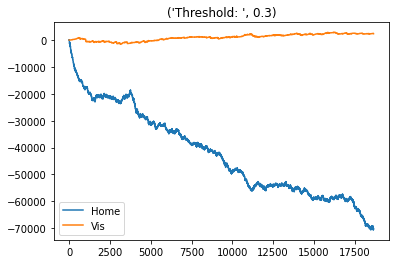

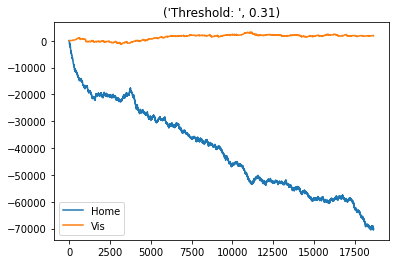

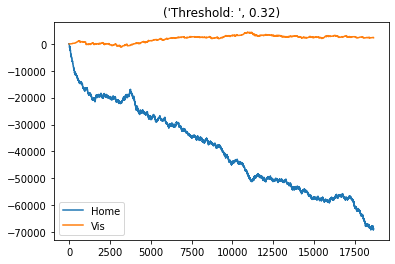

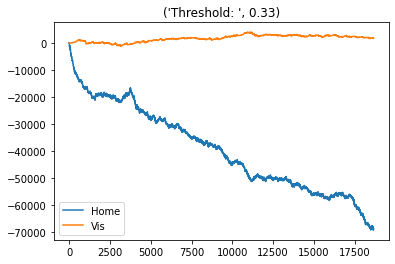

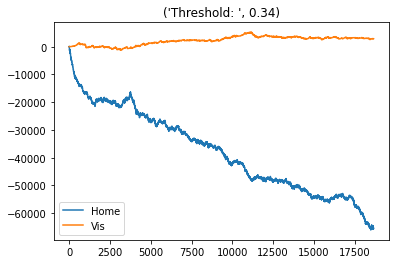

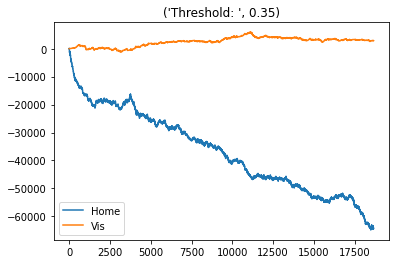

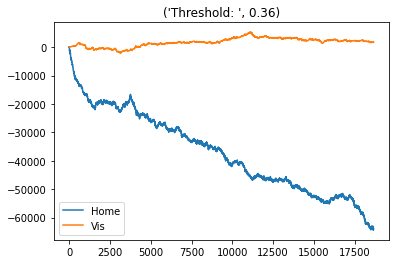

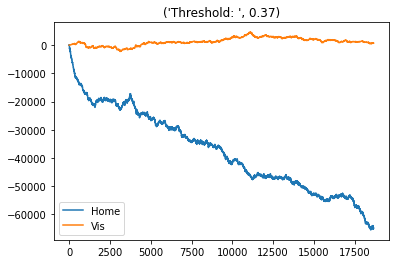

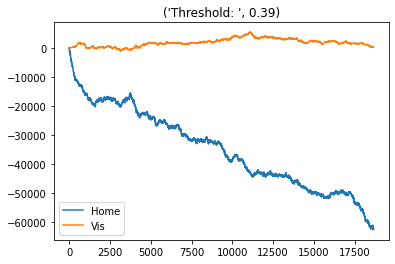

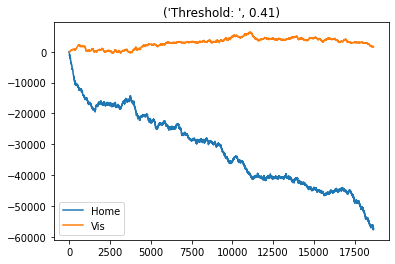

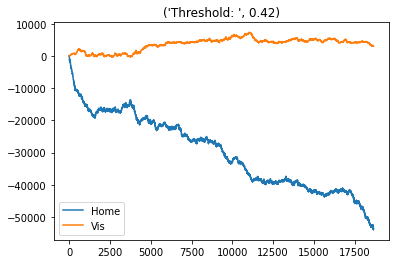

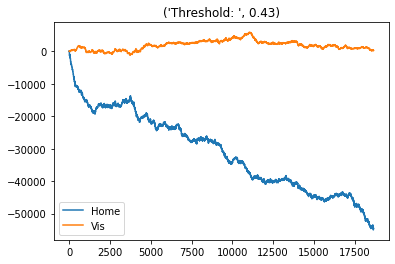

Good results
Amount of games:  18649
{'Threshold': 0.3, 'Home Res': -70295.0, 'Home Bets Made': 16820, '% Bets On': 90, 'Vis Res': 2373.0, 'Vis Bets Made': 1694, '%  Bets On': 9}
{'Threshold': 0.31, 'Home Res': -70151.0, 'Home Bets Made': 16652, '% Bets On': 89, 'Vis Res': 1850.0, 'Vis Bets Made': 1862, '%  Bets On': 10}
{'Threshold': 0.32, 'Home Res': -68897.0, 'Home Bets Made': 16515, '% Bets On': 89, 'Vis Res': 2317.0, 'Vis Bets Made': 1999, '%  Bets On': 11}
{'Threshold': 0.33, 'Home Res': -68893.0, 'Home Bets Made': 16352, '% Bets On': 88, 'Vis Res': 1799.0, 'Vis Bets Made': 2161, '%  Bets On': 12}
{'Threshold': 0.34, 'Home Res': -65414.0, 'Home Bets Made': 16195, '% Bets On': 87, 'Vis Res': 2812.0, 'Vis Bets Made': 2318, '%  Bets On': 12}
{'Threshold': 0.35, 'Home Res': -64266.0, 'Home Bets Made': 16013, '% Bets On': 86, 'Vis Res': 2830.0, 'Vis Bets Made': 2500, '%  Bets On': 13}
{'Threshold': 0.36, 'Home Res': -63958.0, 'Home Bets Made': 15833, '% Bets On': 85, 'Vis Res': 1687.0

In [22]:
results = make_preds(model, x)
plot_df = print_results(results, 'Preds')

In [20]:
good_results = []
calc_result(results, 'Preds', 0.42, good_results)

(            Date  Home Odds  Vis Odds  Home Win     Preds  Home Outcome  \
 0     2008-10-05       1.00      1.00      True  0.623149          0.00   
 1     2008-10-07       1.42      2.88      True  0.689662          0.42   
 2     2008-10-07       1.55      2.45     False  0.640043         -1.00   
 3     2008-10-07       1.42      2.88      True  0.649094          0.42   
 4     2008-10-07       1.37      3.10      True  0.775255          0.37   
 ...          ...        ...       ...       ...       ...           ...   
 18644 2020-10-02       1.17      5.43      True  0.816892          0.17   
 18645 2020-10-04       4.40      1.23      True  0.269668          0.00   
 18646 2020-10-06       3.76      1.30     False  0.330407          0.00   
 18647 2020-10-09       1.31      3.61     False  0.720432         -1.00   
 18648 2020-10-11       3.01      1.42     False  0.421058         -1.00   
 
        Home Bankroll  Vis Outcome  Vis Bankroll  
 0               0.00          0.0 

            Date  Home Odds  Vis Odds  Home Win     Preds
14919 2017-11-14       1.78      2.12      True  0.349632
14920 2017-11-14       1.25      4.29      True  0.765070
14921 2017-11-16       1.59      2.49      True  0.863360
14922 2017-11-16       1.51      2.67      True  0.662962
14923 2017-11-16       1.50      2.73      True  0.663899


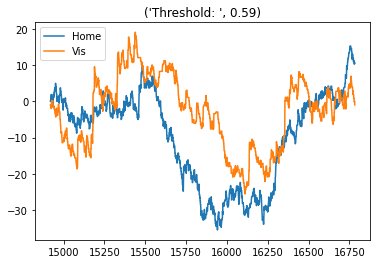

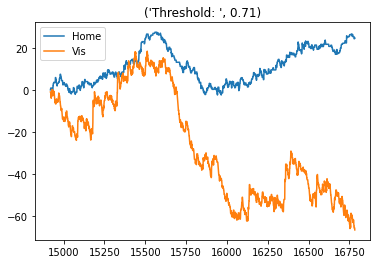

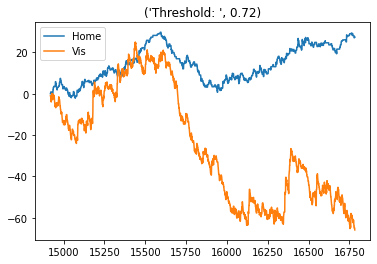

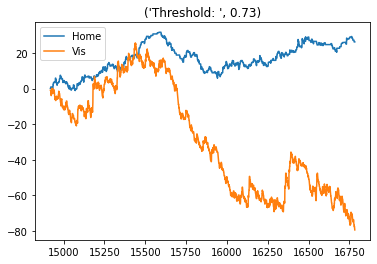

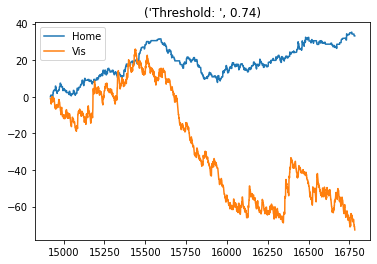

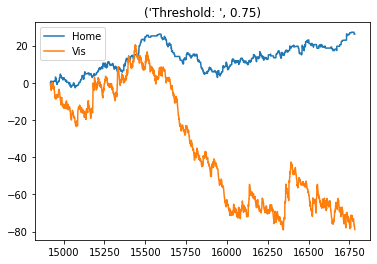

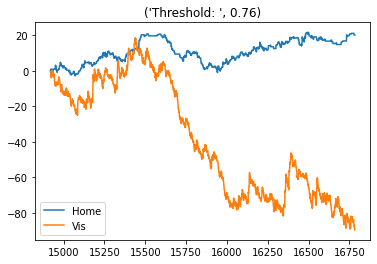

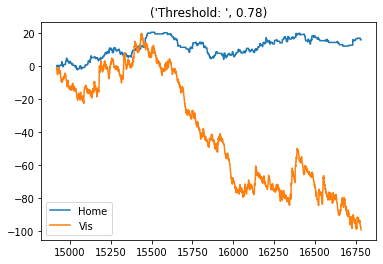

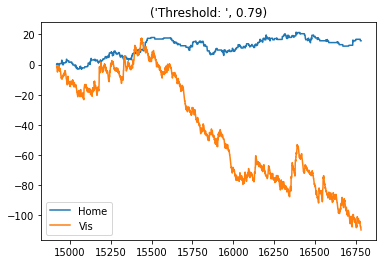

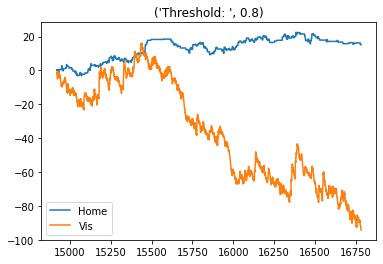

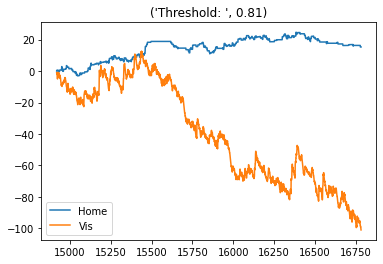

Good results
Amount of games:  1865
{'Threshold': 0.59, 'Home Res': 10.62, 'Home Bets Made': 1168, '% Bets On': 63, 'Vis Res': -0.99, 'Vis Bets Made': 697, '%  Bets On': 37}
{'Threshold': 0.71, 'Home Res': 24.66, 'Home Bets Made': 637, '% Bets On': 34, 'Vis Res': -66.71, 'Vis Bets Made': 1228, '%  Bets On': 66}
{'Threshold': 0.72, 'Home Res': 27.41, 'Home Bets Made': 581, '% Bets On': 31, 'Vis Res': -65.87, 'Vis Bets Made': 1284, '%  Bets On': 69}
{'Threshold': 0.73, 'Home Res': 26.18, 'Home Bets Made': 538, '% Bets On': 29, 'Vis Res': -79.46, 'Vis Bets Made': 1327, '%  Bets On': 71}
{'Threshold': 0.74, 'Home Res': 33.24, 'Home Bets Made': 491, '% Bets On': 26, 'Vis Res': -72.75, 'Vis Bets Made': 1374, '%  Bets On': 74}
{'Threshold': 0.75, 'Home Res': 26.21, 'Home Bets Made': 446, '% Bets On': 24, 'Vis Res': -78.89, 'Vis Bets Made': 1419, '%  Bets On': 76}
{'Threshold': 0.76, 'Home Res': 19.98, 'Home Bets Made': 416, '% Bets On': 22, 'Vis Res': -89.5, 'Vis Bets Made': 1449, '%  Bets On

In [85]:
# Make preds
results = make_preds(model, validX)

# Print results
print_results(results, 'Preds')

In [ ]:
# Grid Search with Keras
## TOOK TOO LONG HAD TO KILL IT

def create_model(learn_rate=1e-6, momentum=0.0, init_mode='uniform', activation='relu', dropout_rate=0.0, weight_constraint=0):
    model = Sequential()
    model.add(Dense(128, input_dim=x.shape[1], activation=activation, kernel_initializer=init_mode, kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(236, activation=activation, kernel_initializer=init_mode, kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(118, activation=activation, kernel_initializer=init_mode, kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(59, activation=activation, kernel_initializer=init_mode, kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(30, activation=activation, kernel_initializer=init_mode, kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(15, activation=activation, kernel_initializer=init_mode, kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation=activation, kernel_initializer=init_mode, kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init_mode))
    
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=create_model, epochs=30)

# Grid Search - Use a coarse grid search first then zoom in on opportunities

param_grid = dict(
    epochs=[10, 20, 30, 40],
    batch_size=[50, 100, 150],
#     optimizer=['SGD', 'Adam', 'RMSProp', 'Adagrad', 'Adadelta', 'Adamax', 'Nadam'],
    learn_rate=[1e-6, 1e-7, 1e-8],
    momentum=[0.0, 0.2,],
    init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
    activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    weight_constraint = [0, 1, 2, 3, 4, 5, 6],
    dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
)

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(x, y)
print('Best score: ',grid_result.best_score_)
print('Best params: ', grid_result.best_params_)

In [ ]:
# TRY WITH RELATIVE BETTING SIZE